In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

In [2]:
os.getcwd()

'/home/student/classifer/models/research/object_detection'

In [3]:
# This is needed to display the images.
%matplotlib inline

In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

In [5]:
NUM_CLASSES = 30

In [6]:
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [12]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 11) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [13]:
print(TEST_IMAGE_PATHS)

['test_images/image3.jpg', 'test_images/image4.jpg', 'test_images/image5.jpg', 'test_images/image6.jpg', 'test_images/image7.jpg', 'test_images/image8.jpg', 'test_images/image9.jpg', 'test_images/image10.jpg']


In [11]:
def filter_boxes(min_score, boxes, scores, classes, categories):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if classes[i] in categories and scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

In [12]:
def get_cropped_images():
    cropped_images=[]
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for image_path in TEST_IMAGE_PATHS:
                image = Image.open(image_path)
                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                time0 = time.time()

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                  [detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

                time1 = time.time()

                boxes = np.squeeze(boxes)
                scores = np.squeeze(scores)
                classes = np.squeeze(classes).astype(np.int32)

                confidence_cutoff = 0.2
                traffic_lights_class_id=10
                # Filter boxes with a confidence score less than `confidence_cutoff`
                boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes,[traffic_lights_class_id])


                #image = Image.open(test_image)
                width = image.size[0]
                height = image.size[1]
                cropped_image = image.crop((0,100,width,height-150))
                width, height = cropped_image.size
                box_coords = to_image_coords(boxes, height, width)

                print(box_coords)
                for box in box_coords:
                    top,left,bottom,right = box
                    traffic_light = cropped_image.crop(
                        (
                           left,
                            top,
                            right,
                            bottom
                        )
                    )
                    cropped_images.append(traffic_light)
            
            return cropped_images

In [36]:
class traffic_signal_detector(object) :
    
    def __init__(self):
        MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
        MODEL_FILE = MODEL_NAME + '.tar.gz'
        PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
        
        NUM_CLASSES = 30
        
        tar_file = tarfile.open(MODEL_FILE)
        for file in tar_file.getmembers():
          file_name = os.path.basename(file.name)
          if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())
            
        detection_graph = tf.Graph()
        with detection_graph.as_default():
          od_graph_def = tf.GraphDef()
          with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
            
            
        with detection_graph.as_default():
            with tf.Session(graph=detection_graph) as self.sess:
                # Definite input and output Tensors for detection_graph
                self.image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

                # Each box represents a part of the image where a particular object was detected.
                self.detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

                # Each score represent how level of confidence for each of the objects.
                # Score is shown on the result image, together with the class label.
                self.detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
                self.detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
                self.num_detections = detection_graph.get_tensor_by_name('num_detections:0')                
            
    def load_image_into_numpy_array(self,image):
      (im_width, im_height) = image.size
      return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)
    
    
    def filter_boxes(self,min_score, boxes, scores, classes, categories):
        """Return boxes with a confidence >= `min_score`"""
        n = len(classes)
        idxs = []
        for i in range(n):
            if classes[i] in categories and scores[i] >= min_score:
                idxs.append(i)

        filtered_boxes = boxes[idxs, ...]
        filtered_scores = scores[idxs, ...]
        filtered_classes = classes[idxs, ...]
        return filtered_boxes, filtered_scores, filtered_classes

    def to_image_coords(self,boxes, height, width):
        """
        The original box coordinate output is normalized, i.e [0, 1].

        This converts it back to the original coordinate based on the image
        size.
        """
        box_coords = np.zeros_like(boxes)
        box_coords[:, 0] = boxes[:, 0] * height
        box_coords[:, 1] = boxes[:, 1] * width
        box_coords[:, 2] = boxes[:, 2] * height
        box_coords[:, 3] = boxes[:, 3] * width

        return box_coords
        
        
    def get_cropped_images(self,image):
        cropped_images=[]
        
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)

        time0 = time.time()

        # Actual detection.
        (boxes, scores, classes, num) = self.sess.run(
          [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
          feed_dict={self.image_tensor: image_np_expanded})

        time1 = time.time()

        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes).astype(np.int32)

        confidence_cutoff = 0.2
        traffic_lights_class_id=10
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = self.filter_boxes(confidence_cutoff, boxes, scores, classes,[traffic_lights_class_id])


        #image = Image.open(test_image)
        width = image.size[0]
        height = image.size[1]
        cropped_image = image.crop((0,100,width,height-150))
        width, height = cropped_image.size
        box_coords = self.to_image_coords(boxes, height, width)

        #print(box_coords)
        for box in box_coords:
            top,left,bottom,right = box
            traffic_light = cropped_image.crop(
                (
                   left,
                    top,
                    right,
                    bottom
                )
            )
            cropped_images.append(traffic_light)
            
        if len(cropped_images) > 0 :
            return cropped_images[0]
        else :
            return None
    
    

In [37]:
sign_detector = traffic_signal_detector()


In [50]:
# Hayoung-Kim/udacity-carnd-capstone
def get_classification(image):
        """Determines the color of the traffic light in the image
        Args:
            image (cv::Mat): image containing the traffic light
        Returns:
            int: ID of traffic light color (specified in styx_msgs/TrafficLight)
        """

        # Transform to HSV and simply count the number of color within the range 
        image = np.uint8(image*255)
        #plt.imshow(image)
        hsv_img = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        
        # red has hue 0 - 10 & 160 - 180 add another filter 
        # TODO  use Guassian mask
        #RED_MIN1 = np.array([0, 100, 100],np.uint8)
        #RED_MAX1 = np.array([50, 255, 255],np.uint8)        
        
        RED_MIN1 = np.array([0, 100, 100],np.uint8)
        RED_MAX1 = np.array([10, 255, 255],np.uint8)        

        RED_MIN2 = np.array([160, 100, 100],np.uint8)
        RED_MAX2 = np.array([179, 255, 255],np.uint8)

        frame_threshed1 = cv2.inRange(hsv_img, RED_MIN1, RED_MAX1) 
        frame_threshed2 = cv2.inRange(hsv_img, RED_MIN2, RED_MAX2)
        if cv2.countNonZero(frame_threshed1) + cv2.countNonZero(frame_threshed2) > 100:
            combine_threshold = frame_threshed1 + frame_threshed2
            #print(cv2.countNonZero(combine_threshold))
            #plt.imshow(combine_threshold,cmap='gray')
            return "red"

        YELLOW_MIN = np.array([40.0/360*255, 100, 100],np.uint8)
        YELLOW_MAX = np.array([66.0/360*255, 255, 255],np.uint8)
        frame_threshed3 = cv2.inRange(hsv_img, YELLOW_MIN, YELLOW_MAX)
        if cv2.countNonZero(frame_threshed3) > 50:
            #plt.imshow(frame_threshed3,cmap='gray')
            return "yellow"

        GREEN_MIN = np.array([90.0/360*255, 100, 100],np.uint8)
        GREEN_MAX = np.array([180.0/360*255, 255, 255],np.uint8)
        frame_threshed4 = cv2.inRange(hsv_img, GREEN_MIN, GREEN_MAX)
        #print("green" + str(cv2.countNonZero(frame_threshed4)))
        if cv2.countNonZero(frame_threshed4) > 50:
            #plt.imshow(frame_threshed4,cmap='gray')
            return "green"

        return "unknown"

In [51]:
from skimage.transform import resize
def traffic_light_detector(image):
    #image = Image.open(image_path)
    traffic_light = sign_detector.get_cropped_images(image)
    
    if traffic_light :       
        arr = np.array(traffic_light)
        resized = resize(arr, (100,40), anti_aliasing=True)
        return get_classification(resized)
    else :
        return "unknown"

/home/student/miniconda3/envs/tensor14/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


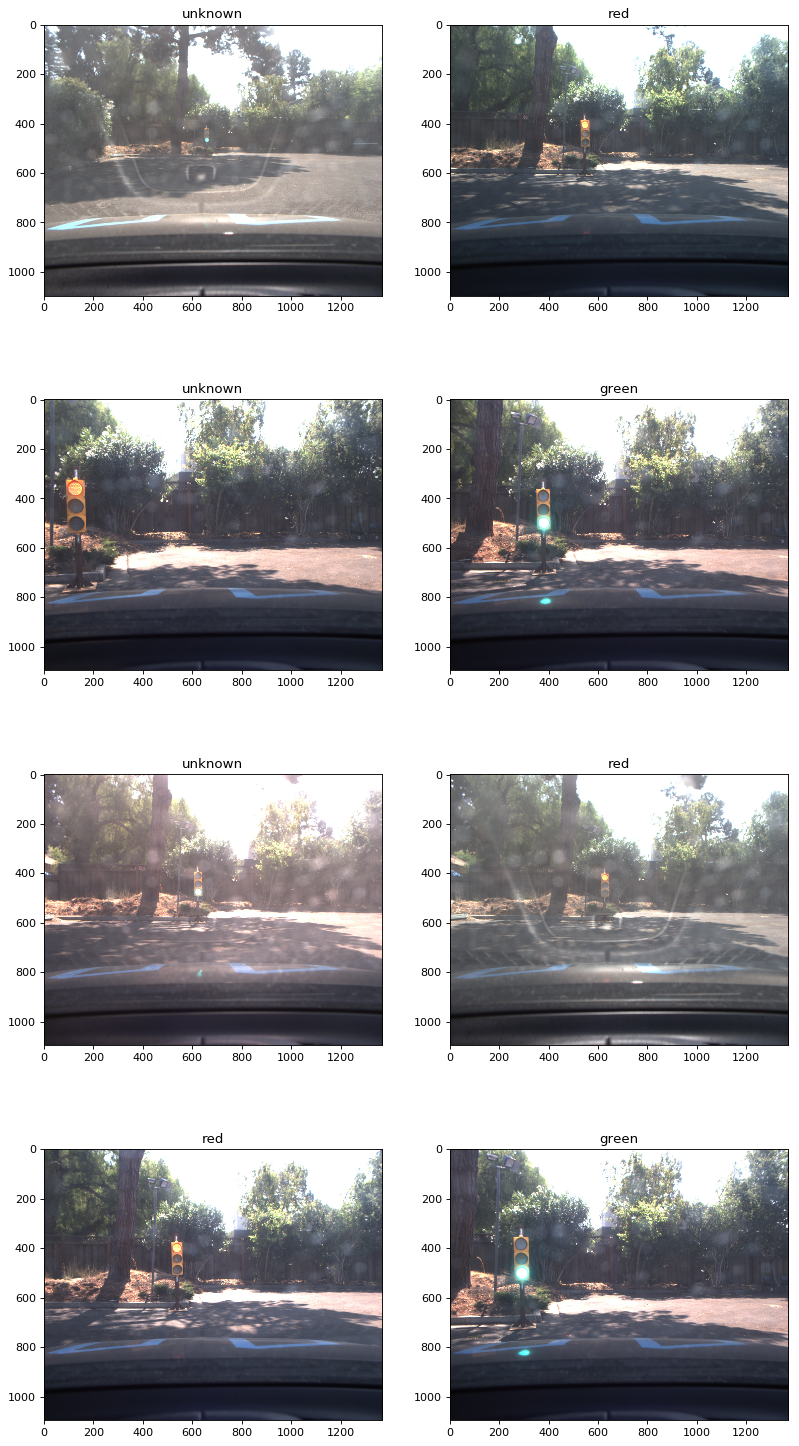

In [55]:

index=1

cols = 2
rows = len(TEST_IMAGE_PATHS)/ cols + 1

fig_hight = rows* 6

plt.figure(num=None, figsize=(12, fig_hight), dpi=80, facecolor='w', edgecolor='k')

for image_path in TEST_IMAGE_PATHS:
    
    image = Image.open(image_path)
    sign = traffic_light_detector(image)
    #print(sign)
    plt.subplot(rows,cols,index)
    plt.title(sign)
    plt.imshow(image)
    index=index+1
    